In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv
/kaggle/input/twitter-sentiment-analysis-hatred-speech/test.csv


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
id       31962 non-null int64
label    31962 non-null int64
tweet    31962 non-null object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
None
   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation


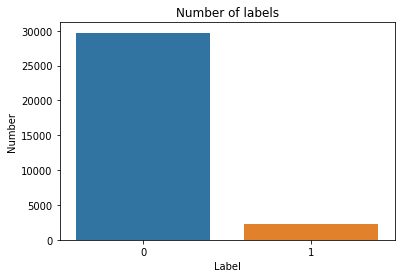

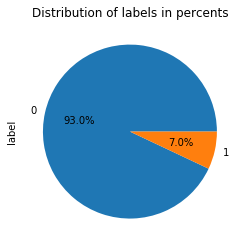

In [2]:
train_data = pd.read_csv('/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv')
test_data = pd.read_csv('/kaggle/input/twitter-sentiment-analysis-hatred-speech/test.csv')

print(train_data.info())
print(train_data.head())
train_labels_count = train_data['label'].value_counts()
sns.barplot(train_labels_count.index,train_labels_count.values)
plt.title('Number of labels'), plt.ylabel('Number'), plt.xlabel('Label')
plt.show()
train_labels_count.plot(kind='pie', autopct = '%1.1f%%')
plt.title('Distribution of labels in percents')
plt.show()


In [3]:
X = train_data['tweet']
y = train_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

def data_cleaning(df):
    tw_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    df = df.apply(lambda x: tw_tokenizer.tokenize(x))
    stopw = stopwords.words('english')
    df = df.apply(lambda x: [item for item in x if item not in stopw] )
    #Count vectorizer accepts strings not lists
    df = df.apply(lambda x: ' '.join(map(str, x)))
    return df

X_train = data_cleaning(X_train)
X_test = data_cleaning(X_test)


vectorizer = CountVectorizer()
tf_train = vectorizer.fit_transform(X_train)
tf_test = vectorizer.transform(X_test)

print(X_train.shape)
print(y_train.shape)


(25569,)
(25569,)


In [4]:
model = MultinomialNB(alpha=0.01)
model.fit(tf_train, y_train)
predictions = model.predict(tf_test)

In [5]:
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.9569842014703582
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5972
           1       0.68      0.65      0.67       421

    accuracy                           0.96      6393
   macro avg       0.83      0.82      0.82      6393
weighted avg       0.96      0.96      0.96      6393



In [6]:
# with StratifiedShuffleSplit

X = train_data['tweet']
y = train_data['label']

shuffle_stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

def data_cleaning(df):
    tw_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    df = df.apply(lambda x: tw_tokenizer.tokenize(x))
    stopw = stopwords.words('english')
    df = df.apply(lambda x: [item for item in x if item not in stopw] )
    #Count vectorizer accepts strings not lists
    df = df.apply(lambda x: ' '.join(map(str, x)))
    return df

X = data_cleaning(X)
tweets = X.values
labels = y.values

for train_index, test_index in shuffle_stratified.split(tweets, labels):
    tweets_train, tweets_test = tweets[train_index], tweets[test_index]
    labels_train, labels_test = labels[train_index], labels[test_index]

vectorizer = CountVectorizer()
tfs_train = vectorizer.fit_transform(tweets_train)
tfs_test = vectorizer.transform(tweets_test)
print(tfs_train.shape)
print(tfs_test.shape)



(25569, 35844)
(6393, 35844)


In [7]:
model = MultinomialNB(alpha=0.01)
model.fit(tfs_train, labels_train)
predictions2 = model.predict(tfs_test)
print(accuracy_score(labels_test, predictions2))
print(classification_report(labels_test, predictions2))

0.9618332551227905
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5945
           1       0.74      0.69      0.72       448

    accuracy                           0.96      6393
   macro avg       0.86      0.84      0.85      6393
weighted avg       0.96      0.96      0.96      6393



In [8]:
# Applying over-sampling to balance the categories

from imblearn.over_sampling import SMOTE

X = train_data['tweet']
y = train_data['label']

def data_cleaning(df):
    tw_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    df = df.apply(lambda x: tw_tokenizer.tokenize(x))
    stopw = stopwords.words('english')
    df = df.apply(lambda x: [item for item in x if item not in stopw] )
    #Count vectorizer accepts strings not lists
    df = df.apply(lambda x: ' '.join(map(str, x)))
    return df

X = data_cleaning(X)
tweets = X.values
labels = y.values

print(tweets.shape)

vectorizer = CountVectorizer()
tweets_numerical = vectorizer.fit_transform(tweets)

sm = SMOTE(random_state=12, ratio = 0.75)
x_res, y_res = sm.fit_sample(tweets_numerical, labels)
print(tweets_numerical.shape)
print(x_res.shape)

x_train_res, x_val_res, y_train_res, y_val_res = train_test_split(x_res, y_res, test_size=0.2)

# model = MultinomialNB(alpha=0.01)
# model.fit(x_train_res, y_train_res)
# predictions3 = model.predict(x_val_res)
# print(accuracy_score(y_val_res, predictions3))
# print(classification_report(y_val_res, predictions3))


from sklearn import svm
from sklearn.metrics import classification_report

classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(x_train_res, y_train_res)
pred = classifier_linear.predict(x_val_res)
print(accuracy_score(y_val_res, pred))
print(classification_report(y_val_res, pred))


Using TensorFlow backend.


(31962,)
(31962, 41215)
(52010, 41215)
0.9502018842530283
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      5982
           1       0.92      0.97      0.94      4420

    accuracy                           0.95     10402
   macro avg       0.95      0.95      0.95     10402
weighted avg       0.95      0.95      0.95     10402



In [9]:
X = train_data['tweet']
y = train_data['label']

shuffle_stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

def data_cleaning(df):
    tw_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    df = df.apply(lambda x: tw_tokenizer.tokenize(x))
    stopw = stopwords.words('english')
    df = df.apply(lambda x: [item for item in x if item not in stopw] )
    #Count vectorizer accepts strings not lists
    df = df.apply(lambda x: ' '.join(map(str, x)))
    return df

X = data_cleaning(X)
tweets = X.values
labels = y.values

for train_index, test_index in shuffle_stratified.split(tweets, labels):
    tweets_train, tweets_test = tweets[train_index], tweets[test_index]
    labels_train, labels_test = labels[train_index], labels[test_index]

vectorizer = CountVectorizer()
tfs_train = vectorizer.fit_transform(tweets_train)
tfs_test = vectorizer.transform(tweets_test)
print(tfs_train.shape)
print(tfs_test.shape)

from sklearn import svm
from sklearn.metrics import classification_report

classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(tfs_train, labels_train)
pred = classifier_linear.predict(tfs_test)
print(accuracy_score(labels_test, pred))
print(classification_report(labels_test, pred))

(25569, 35951)
(6393, 35951)
0.9602690442671672
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5945
           1       0.77      0.62      0.69       448

    accuracy                           0.96      6393
   macro avg       0.87      0.81      0.83      6393
weighted avg       0.96      0.96      0.96      6393

